Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [66]:
# Mounting through google drive
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/colab-ground/melanoma-detection-assignment/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/colab-ground/melanoma-detection-assignment/Test")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Creating train and validation datasets


In [5]:
# Defining parameters
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
# Train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
# Validation dataset
val_ds =  tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# Printing class names
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualizing the data

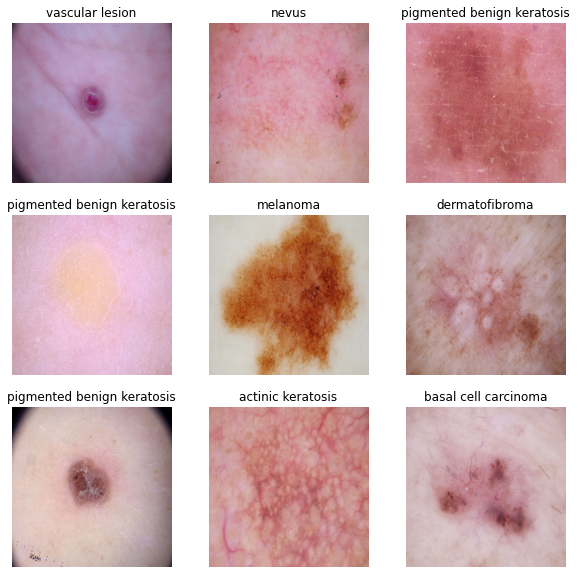

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating Model
#### Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). 

In [11]:
num_classes = len(class_names)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compiling the model
Using adam optimiser and Crossentrophy loss function

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Training the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 308s 2s/step - loss: 2.0727 - accuracy: 0.2020 - val_loss: 1.9814 - val_accuracy: 0.2394
Epoch 2/20
56/56 [==============================] - 3s 49ms/step - loss: 1.8399 - accuracy: 0.3153 - val_loss: 1.5697 - val_accuracy: 0.4609
Epoch 3/20
56/56 [==============================] - 3s 46ms/step - loss: 1.4614 - accuracy: 0.4922 - val_loss: 1.5068 - val_accuracy: 0.4743
Epoch 4/20
56/56 [==============================] - 3s 47ms/step - loss: 1.3124 - accuracy: 0.5452 - val_loss: 1.5045 - val_accuracy: 0.5034
Epoch 5/20
56/56 [==============================] - 3s 47ms/step - loss: 1.2536 - accuracy: 0.5569 - val_loss: 1.5978 - val_accuracy: 0.5369
Epoch 6/20
56/56 [==============================] - 3s 47ms/step - loss: 1.1603 - accuracy: 0.5882 - val_loss: 1.3659 - val_accuracy: 0.5503
Epoch 7/20
56/56 [==============================] - 3s 47ms/step - loss: 1.0304 - accuracy: 0.6189 - val_loss: 1.5754 - val_accuracy: 0.5101
Epoch 8/20
56

### Visualizing training results

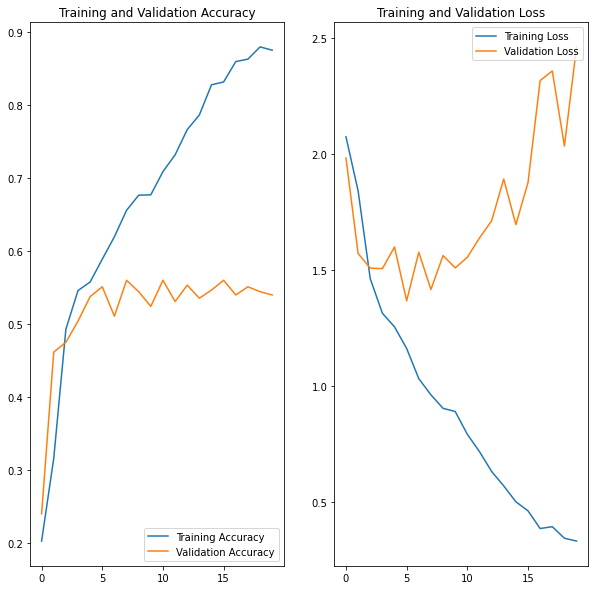

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### From the graph training accuracy is more than validation accuracy which is around 55%. Therefore model is perfoming well on training data but not on validation because of overfitting

In [16]:
# Using data augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


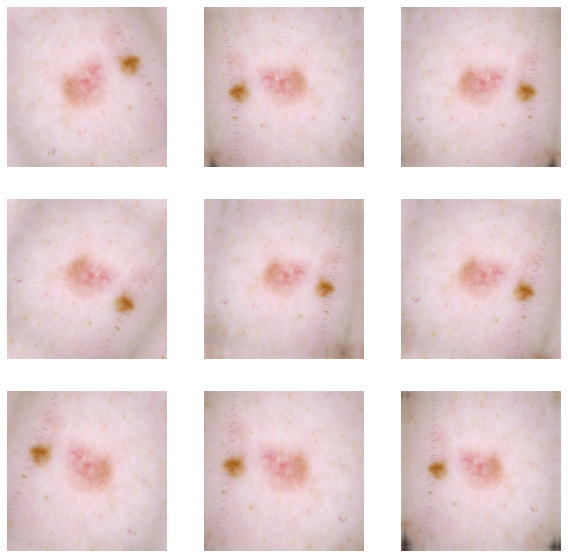

In [17]:
# Visualising augmented images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


### Creating the model with augmentation and dropout layer

In [18]:

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])




### Compiling the model

In [19]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [20]:
# Model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Training the model

In [21]:
history = epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20
56/56 [==============================] - 5s 58ms/step - loss: 2.0715 - accuracy: 0.2266 - val_loss: 1.9809 - val_accuracy: 0.2192
Epoch 2/20
56/56 [==============================] - 3s 54ms/step - loss: 1.7872 - accuracy: 0.3566 - val_loss: 1.7135 - val_accuracy: 0.3803
Epoch 3/20
56/56 [==============================] - 3s 53ms/step - loss: 1.4722 - accuracy: 0.4838 - val_loss: 1.5015 - val_accuracy: 0.5078
Epoch 4/20
56/56 [==============================] - 3s 54ms/step - loss: 1.4694 - accuracy: 0.4821 - val_loss: 1.4040 - val_accuracy: 0.5235
Epoch 5/20
56/56 [==============================] - 3s 54ms/step - loss: 1.3632 - accuracy: 0.5033 - val_loss: 1.3505 - val_accuracy: 0.5257
Epoch 6/20
56/56 [==============================] - 3s 53ms/step - loss: 1.3526 - accuracy: 0.5206 - val_loss: 1.3275 - val_accuracy: 0.5436
Epoch 7/20
56/56 [==============================] - 3s 53ms/step - loss: 1.2910 - accuracy: 0.5318 - val_loss: 1.3136 - val_accuracy: 0.5324
Epoch 8/20
56

### Visualizing the results

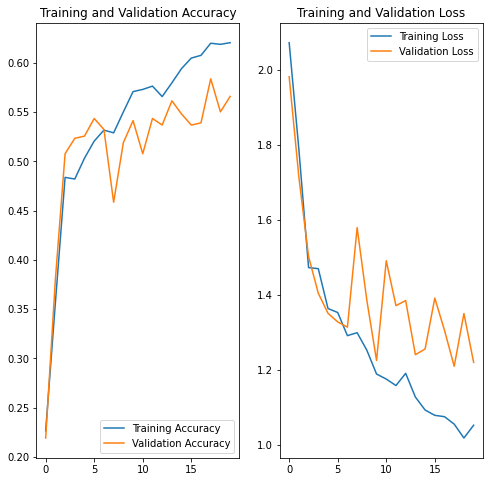

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model overfitting got reduced after using data augmentation and dropout to the model

#### Checking class imbalance

In [27]:
for class_name in class_names:
  class_count = len(list(data_dir_train.glob(class_name+'/*.jpg')))
  print(class_name +": "+str(class_count))

actinic keratosis: 114
basal cell carcinoma: 376
dermatofibroma: 95
melanoma: 438
nevus: 357
pigmented benign keratosis: 462
seborrheic keratosis: 77
squamous cell carcinoma: 181
vascular lesion: 139


#### - Which class has the least number of samples?
#### - seborrheic keratosis has least number of samples
#### - Which classes dominate the data in terms proportionate number of samples?
#### - pigmented benign keratosis, melanoma & basal cell carcinoma have more samples compared to other classes


#### Using `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [28]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [29]:
path_to_training_dataset="/content/gdrive/MyDrive/colab-ground/melanoma-detection-assignment/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/colab-ground/melanoma-detection-assignment/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F508C4A75D0>: 100%|██████████| 500/500 [00:21<00:00, 23.77 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/colab-ground/melanoma-detection-assignment/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5104B8FED0>: 100%|██████████| 500/500 [00:21<00:00, 23.30 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/colab-ground/melanoma-detection-assignment/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F508C4FCC10>: 100%|██████████| 500/500 [00:23<00:00, 21.67 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/colab-ground/melanoma-detection-assignment/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F5104B962D0>: 100%|██████████| 500/500 [02:07<00:00,  3.92 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/colab-ground/melanoma-detection-assignment/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=576x768 at 0x7F5104B8FC50>: 100%|██████████| 500/500 [01:32<00:00,  5.40 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/colab-ground/melanoma-detection-assignment/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5104A72E90>: 100%|██████████| 500/500 [00:21<00:00, 22.96 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/colab-ground/melanoma-detection-assignment/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F508CA58F50>: 100%|██████████| 500/500 [00:48<00:00, 10.21 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/colab-ground/melanoma-detection-assignment/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F508C4F3490>: 100%|██████████| 500/500 [00:21<00:00, 23.19 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/colab-ground/melanoma-detection-assignment/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F508CA5F150>: 100%|██████████| 500/500 [00:21<00:00, 22.75 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [30]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [31]:
from glob import glob

In [32]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/colab-ground/melanoma-detection-assignment/Train/vascular lesion/output/vascular lesion_original_ISIC_0033349.jpg_e7e99e58-9341-4c41-9033-f885737c0b87.jpg',
 '/content/gdrive/MyDrive/colab-ground/melanoma-detection-assignment/Train/vascular lesion/output/vascular lesion_original_ISIC_0033565.jpg_09a565f9-70db-482c-9350-62ff3ef83a94.jpg',
 '/content/gdrive/MyDrive/colab-ground/melanoma-detection-assignment/Train/vascular lesion/output/vascular lesion_original_ISIC_0030070.jpg_a77ae689-41ff-48c4-bfc7-090bcbf072d7.jpg',
 '/content/gdrive/MyDrive/colab-ground/melanoma-detection-assignment/Train/vascular lesion/output/vascular lesion_original_ISIC_0027385.jpg_82bf13ab-4758-4256-95a0-c3320f41f239.jpg',
 '/content/gdrive/MyDrive/colab-ground/melanoma-detection-assignment/Train/vascular lesion/output/vascular lesion_original_ISIC_0032867.jpg_1a9233f2-e610-49c7-a148-2d9e098a9a27.jpg',
 '/content/gdrive/MyDrive/colab-ground/melanoma-detection-assignment/Train/vascular l

In [33]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [34]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [35]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2.head()

,Path,Label
0,/content/gdrive/MyDrive/colab-ground/melanoma-...,vascular lesion
1,/content/gdrive/MyDrive/colab-ground/melanoma-...,vascular lesion
2,/content/gdrive/MyDrive/colab-ground/melanoma-...,vascular lesion
3,/content/gdrive/MyDrive/colab-ground/melanoma-...,vascular lesion
4,/content/gdrive/MyDrive/colab-ground/melanoma-...,vascular lesion


#### Training the model on the data created using Augmentor

In [36]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [57]:
# Creating a new train directory from train and augmentor data
import shutil

parent_path = '/content/gdrive/MyDrive/colab-ground/melanoma-detection-assignment/'
for class_name in class_names:
  class_dir = class_name
  new_train_dir = "New_Train"
  path = os.path.join(parent_path, new_train_dir, class_dir)
  os.mkdir(path)
  src_dir = os.path.join(parent_path+"Train/"+class_name)
  dest_dir = path
  for src_file in pathlib.Path(src_dir).glob('*.jpg'):
    shutil.copy(src_file, dest_dir)
  src_output_dir = os.path.join(src_dir,"output")
  for src_file in pathlib.Path(src_output_dir).glob('*.jpg'):
    shutil.copy(src_file, dest_dir)


In [60]:
# Train dataset
data_dir_train_new = pathlib.Path("/content/gdrive/MyDrive/colab-ground/melanoma-detection-assignment/New_Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train_new,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [61]:
# Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train_new,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Creating model

In [62]:
num_classes = len(class_names)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### Compiling the model

In [63]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [64]:
# Model Summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

#### Training the model

In [65]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 41s 233ms/step - loss: 1.9629 - accuracy: 0.2491 - val_loss: 1.5078 - val_accuracy: 0.4358
Epoch 2/50
169/169 [==============================] - 41s 233ms/step - loss: 1.4396 - accuracy: 0.4605 - val_loss: 1.3367 - val_accuracy: 0.4989
Epoch 3/50
169/169 [==============================] - 40s 228ms/step - loss: 1.2068 - accuracy: 0.5480 - val_loss: 1.1814 - val_accuracy: 0.5546
Epoch 4/50
169/169 [==============================] - 40s 232ms/step - loss: 1.0648 - accuracy: 0.6074 - val_loss: 1.0758 - val_accuracy: 0.6013
Epoch 5/50
169/169 [==============================] - 40s 231ms/step - loss: 0.8914 - accuracy: 0.6769 - val_loss: 1.1113 - val_accuracy: 0.6214
Epoch 6/50
169/169 [==============================] - 40s 232ms/step - loss: 0.7224 - accuracy: 0.7361 - val_loss: 1.0144 - val_accuracy: 0.6511
Epoch 7/50
169/169 [==============================] - 40s 229ms/step - loss: 0.5954 - accuracy: 0.7889 - val_loss: 0.9126 - val_ac

#### Visualising the model results

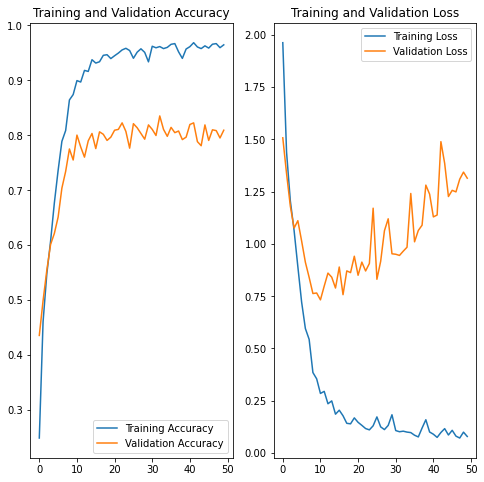

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Did you get rid of underfitting/overfitting? Did class rebalance help?



Using augmented images to handle class imbalance reduced overfitting and improved accuracy

In [73]:
# Predicting on sample image from test set

img_path = '/content/gdrive/MyDrive/colab-ground/melanoma-detection-assignment/Test/basal cell carcinoma/ISIC_0024345.jpg'
img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to basal cell carcinoma with a 92.81 percent confidence.
